### 전처리

> Data
- Input: FMguide에서 다운받은 excel 파일
- Output: csv file (아웃라이어 찾기, Stationary 적용 전 파일)

> Process
1. Excel 데이터 불러오고 기본 데이터프레임 형식으로 전처리
2. rf(risk free rate) 데이터(yfinance) 불러오기 및 데이터 병합
3. ROE 계산
4. COE 계산
5. GM 계산
6. 일반수익률 계산(n일 후 종목 종가 - 종목 종가 / 종목 종가)
7. 상대수익률 계산(종목 수익률 - 시장 수익률)
8. 데이터 내보내기

> 코드 구현 날짜
- 2023-11-01

> 개발환경
- Python version: 3.8.18

> 수정내용
- 수정날짜: 2023-11-08  
- 수정내용:
1. 전처리 코드 함수화
2. 새로 다운받은 20년치 데이터 중 최근 10년 데이터 전처리 및 각종 지표 계산

- 수정날짜: 2023-11-13
- 수정내용:  
1. ROE 계산법 변경
- 기존: 연도별 평균 ROE 계산  
예) 2020년 2분기 ROE = 2020년 1,2,3,4분기의 평균 계산  
2023년 2분기 경우에는 2023년 1,2분기의 평균값을 계산하였음.

- 변경후: 이동평균 ROE 계산(중첩하며 평균 ROE 계산)  
예) 2020년 2분기 ROE = 2019년 3,4분기와 2020년 1,2분기의 평균 계산

- 수정날짜: 2023-11-19
- 수정내용:
1. 변경된 ROE 계산법을 통해 ROE 계산에 필요한 모든 컬럼에 다 계단식 평균 구하기 적용

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import os

# 한글과 음수 부호가 제대로 표시되는 폰트로 변경
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 표시 문제 해결

In [2]:
# 변수 정의

# 회사 리스트
company_list = ['SK텔레콤', 'KT', 'LG유플러스', '농심', 'CJ제일제당', '오뚜기', '현대차', '한국타이어', 'KB금융', '신한지주']
company = company_list[2] # 회사 선택

# 기간 설정 -> 10년치 데이터만 가져옴
start_dt = '2012-07-01'
end_dt = '2023-06-30'

# 엑셀 파일 경로
filename = '../FMguide_data/gm_model_20years.xlsx'  

### FMguide 데이터 가져오기

In [3]:
# 전처리 함수
def load_data_guide(filename, sheet_name):
    raw_df = pd.read_excel(filename, sheet_name=sheet_name)
    col = raw_df[11:12] # 컬럼명 가져오기
    data = raw_df[13:] # 데이터 가져오기
    df = pd.concat([col, data]) # 컬럼명, 데이터 병합
    df.columns = df.iloc[0] # 컬럼 지정
    df.drop(df.index[0], inplace=True) # 필요없는 첫 행 삭제
    df.rename(columns={df.columns[0]:'Date'}, inplace=True) # 첫번째 컬럼의 컬럼명 변경
    df['Date'] = pd.to_datetime(df['Date']) # 시간형태로 변환
    df = df[(df['Date'] >= start_dt) & (df['Date'] <= end_dt)] # 원하는 기간 설정
    return df

In [4]:
# 함수를 사용해서 파일 읽기
df = load_data_guide(filename, company)
print("회사명: ", company)
df.head()

회사명:  LG유플러스


11,Date,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),종가(원),총자본(천원),PBR(배)
2491,2012-07-02,-10336000,-56562000,173000,5510,3730074000,0.5607
2492,2012-07-03,-10336000,-56562000,173000,5570,3730074000,0.56681
2493,2012-07-04,-10336000,-56562000,173000,5530,3730074000,0.56274
2494,2012-07-05,-10336000,-56562000,173000,5530,3730074000,0.56274
2495,2012-07-06,-10336000,-56562000,173000,5470,3730074000,0.55663


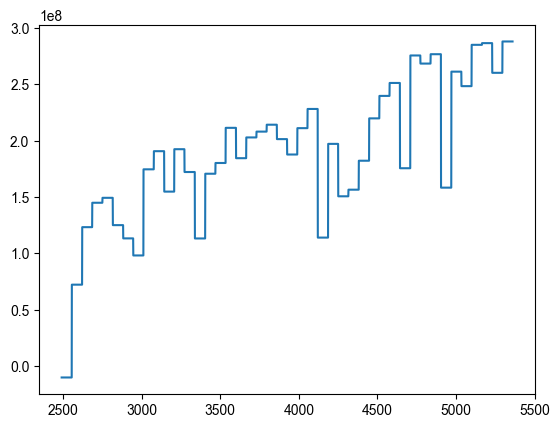

In [5]:
plt.plot(df['영업이익(천원)'])

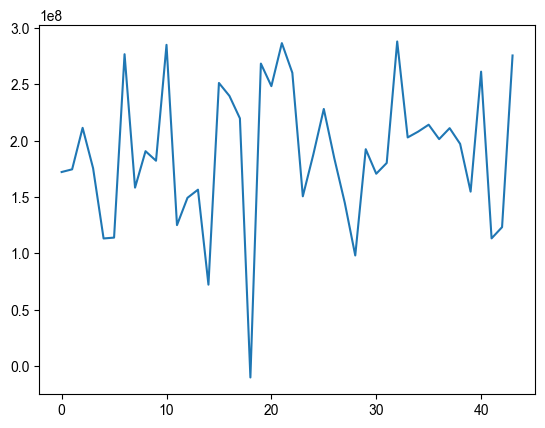

In [6]:
plt.plot(df['영업이익(천원)'].value_counts().index)

### COE 계산을 위한 rf 데이터 불러오기

- rf: risk free(미국채 10년물)

In [7]:
# 미국 국채 10년물 불러오는 함수
def load_us_10_year_data(start_date, end_date):
    us_10_year = yf.download("^TNX", start=start_date, end=end_date)
    us_10_year.rename(columns={'Close': 'us_10_treasury'}, inplace=True) # 컬럼명 변경
    us_10_year = us_10_year.reset_index() # Date(인덱스) -> 컬럼으로
    us_10_year = us_10_year[['Date', 'us_10_treasury']] # Date와 미국채 10년물만 가져오기
    return us_10_year

In [8]:
# 데이터 병합
us_10_year = load_us_10_year_data(start_dt, end_dt)
df = pd.merge(df, us_10_year, on='Date', how='outer') # 기존 df와 us_10_year데이터를 Date컬럼 기준으로 merge
df['us_10_treasury'] = df['us_10_treasury'].fillna(method='ffill') # us_10_treasury의 na 값을 ffill로(전날)데이터로 채워줌
#df = df.dropna() # NA인 행 삭제. NA라는 것은 영업일이 아니라는 의미이기 때문(공휴일인듯?)

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'us_10_treasury')

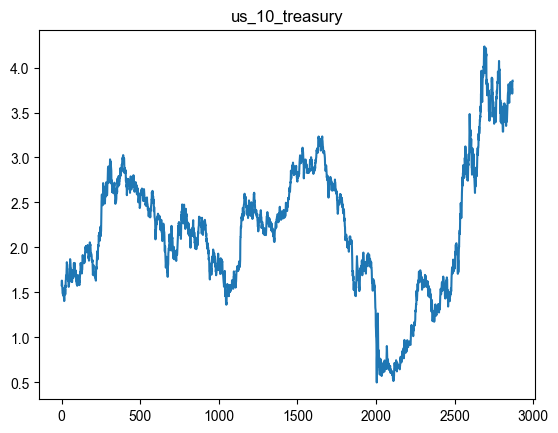

In [9]:
plt.plot(df['us_10_treasury'])
plt.title('us_10_treasury')

### Equity(총자본(천원)) 계산

In [10]:
# 분기 나누는 함수
def get_quarter(date):
    year = date.year
    month = date.month

    if 2003 <= year <= 2023:
        if 1 <= month <= 3:
            return f'{year}Q1'
        elif 4 <= month <= 6:
            return f'{year}Q2'
        elif 7 <= month <= 9:
            return f'{year}Q3'
        elif 10 <= month <= 12:
            return f'{year}Q4'
    else:
        return None

In [11]:
df['Quarter'] = df['Date'].apply(get_quarter)

### COE 계산

COE = rf + Beta(MRP)

- Beta: 1
- MRP: 4%
- rf: 미국 국채 10년물

In [12]:
# beta랑 MRP 값
beta = 1
MRP = 4

In [13]:
df['COE'] = df['us_10_treasury'] + beta*MRP

Text(0.5, 1.0, 'COE')

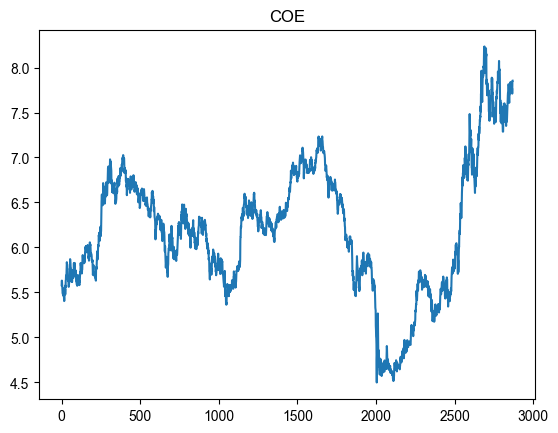

In [14]:
plt.plot(df['COE'])
plt.title("COE")

### ROE, Growth Multiplier 계산

- 순이익 = 영업이익 + 금융손익 + EMS *(1-20%)
- ROE = 순이익 / 총자본
- gm = PBR * COE / ROE

(1-20%): 법인세

In [15]:
# # 천원 단위 -> 원 단위
# df['영업이익(원)'] = df['영업이익(천원)'] * 1000
# df['금융손익(비영업)(원)'] = df['금융손익(비영업)(천원)'] * 1000
# df['관계기업투자등관련손익(비영업)(원)'] = df['관계기업투자등관련손익(비영업)(천원)'] * 1000
# df['총자본(원)'] = df['총자본(천원)'] * 1000

# # 천원 단위 컬럼 삭제
# df.drop(columns=['영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '총자본(천원)'], inplace=True)

In [16]:
# 년도와 분기를 포함한 컬럼 생성
df['YearQuarter'] = df['Date'].dt.to_period('Q')

In [17]:
#지수표현식 없애기 
pd.options.display.float_format = '{:.5f}'.format


#되돌리기
pd.reset_option('display.float_format')

In [18]:
# YearQuarter 별로 가장 첫번째 값만 가져오는 코드
gr_yq_df = df.groupby('YearQuarter').agg({
    '영업이익(천원)': 'first',
    '금융손익(비영업)(천원)': 'first',
    '관계기업투자등관련손익(비영업)(천원)': 'first',
    '총자본(천원)': 'first'
})

# 모든 컬럼을 정수형으로 변환
for column in gr_yq_df.columns:
    gr_yq_df[column] = gr_yq_df[column].astype(int)

In [19]:
gr_yq_df

,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),총자본(천원)
YearQuarter,,,,
2012Q3,-10336000,-56562000,173000,3730074000
2012Q4,72084000,-60772000,-79000,3748500000
2013Q1,123153000,-36864000,301000,3820191000
2013Q2,144818000,-49885000,213000,3907798000
2013Q3,149210000,-48767000,216000,3981683000
2013Q4,124948000,-61094000,249000,4022616000
2014Q1,113185000,-44736000,442000,3983603000
2014Q2,98026000,-69360000,507000,4013886000
2014Q3,174509000,-52236000,89000,4103313000


In [20]:
# 이동 평균을 계산하는 함수 정의
def move_mean(data, window_size=4):
    M = [None] * (window_size - 1)  # 첫 window_size - 1개는 NA로 채움
    for n in range(len(data) - window_size + 1):
        move_mean = sum(data[n:n+window_size]) / window_size
        M.append(int(move_mean))  # 계산된 이동 평균을 정수형으로 변환
    return M


In [21]:
# 각 컬럼에 대해 이동 평균을 계산
for column in ['영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '총자본(천원)']:
    gr_yq_df[column + '_mean'] = move_mean(gr_yq_df[column])

gr_yq_df.head()

,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),총자본(천원),영업이익(천원)_mean,금융손익(비영업)(천원)_mean,관계기업투자등관련손익(비영업)(천원)_mean,총자본(천원)_mean
YearQuarter,,,,,,,,
2012Q3,-10336000,-56562000,173000,3730074000,NaN,NaN,NaN,NaN
2012Q4,72084000,-60772000,-79000,3748500000,NaN,NaN,NaN,NaN
2013Q1,123153000,-36864000,301000,3820191000,NaN,NaN,NaN,NaN
2013Q2,144818000,-49885000,213000,3907798000,82429750.0,-51020750.0,152000.0,3.801641e+09
2013Q3,149210000,-48767000,216000,3981683000,122316250.0,-49072000.0,162750.0,3.864543e+09


In [22]:
# 모든 컬럼을 정수형으로 변환
for column in gr_yq_df.columns:
    gr_yq_df[column] = pd.to_numeric(gr_yq_df[column], errors='coerce').astype('Int64')

In [23]:
df = pd.merge(df, gr_yq_df[['영업이익(천원)_mean', '금융손익(비영업)(천원)_mean', '관계기업투자등관련손익(비영업)(천원)_mean', '총자본(천원)_mean']], on='YearQuarter')

In [24]:
#df.to_excel('중첩평균계산.xlsx', )

In [25]:
df.columns

Index(['Date', '영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '종가(원)',
       '총자본(천원)', 'PBR(배)', 'us_10_treasury', 'Quarter', 'COE', 'YearQuarter',
       '영업이익(천원)_mean', '금융손익(비영업)(천원)_mean', '관계기업투자등관련손익(비영업)(천원)_mean',
       '총자본(천원)_mean'],
      dtype='object')

In [26]:
df_cleaned = df.dropna()

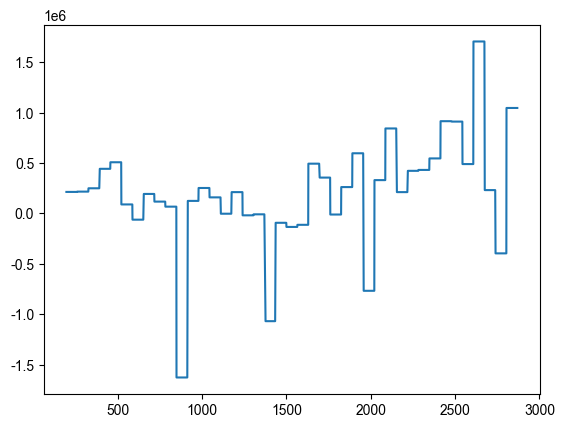

In [27]:
plt.plot(df_cleaned['관계기업투자등관련손익(비영업)(천원)'])

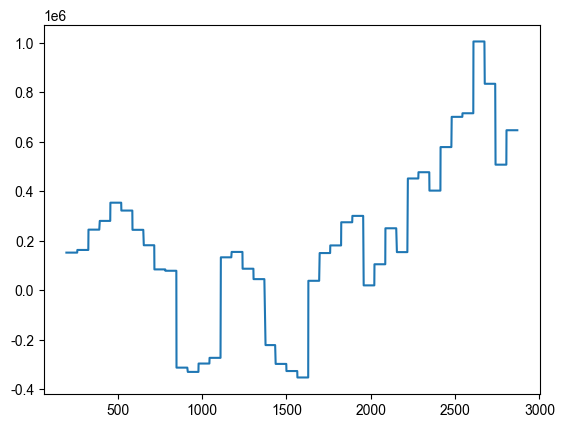

In [28]:
plt.plot(df_cleaned['관계기업투자등관련손익(비영업)(천원)_mean'])

In [29]:
gr_yq_df

,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),총자본(천원),영업이익(천원)_mean,금융손익(비영업)(천원)_mean,관계기업투자등관련손익(비영업)(천원)_mean,총자본(천원)_mean
YearQuarter,,,,,,,,
2012Q3,-10336000,-56562000,173000,3730074000,<NA>,<NA>,<NA>,<NA>
2012Q4,72084000,-60772000,-79000,3748500000,<NA>,<NA>,<NA>,<NA>
2013Q1,123153000,-36864000,301000,3820191000,<NA>,<NA>,<NA>,<NA>
2013Q2,144818000,-49885000,213000,3907798000,82429750,-51020750,152000,3801640750
2013Q3,149210000,-48767000,216000,3981683000,122316250,-49072000,162750,3864543000
2013Q4,124948000,-61094000,249000,4022616000,135532250,-49152500,244750,3933072000
2014Q1,113185000,-44736000,442000,3983603000,133040250,-51120500,280000,3973925000
2014Q2,98026000,-69360000,507000,4013886000,121342250,-55989250,353500,4000447000
2014Q3,174509000,-52236000,89000,4103313000,127667000,-56856500,321750,4030854500


In [30]:
# YearQuarter 별로 가장 첫번째 값만 가져오는 코드
df_cleaned_gr = df_cleaned.groupby('YearQuarter').agg({
    'ROE': 'first',
    'gm': 'first',
    'COE': 'first'
})

df_cleaned_gr

KeyError: "Column(s) ['ROE', 'gm'] do not exist"

In [31]:
plt.plot(df_cleaned['gm'])

KeyError: 'gm'

NameError: name 'ax3' is not defined

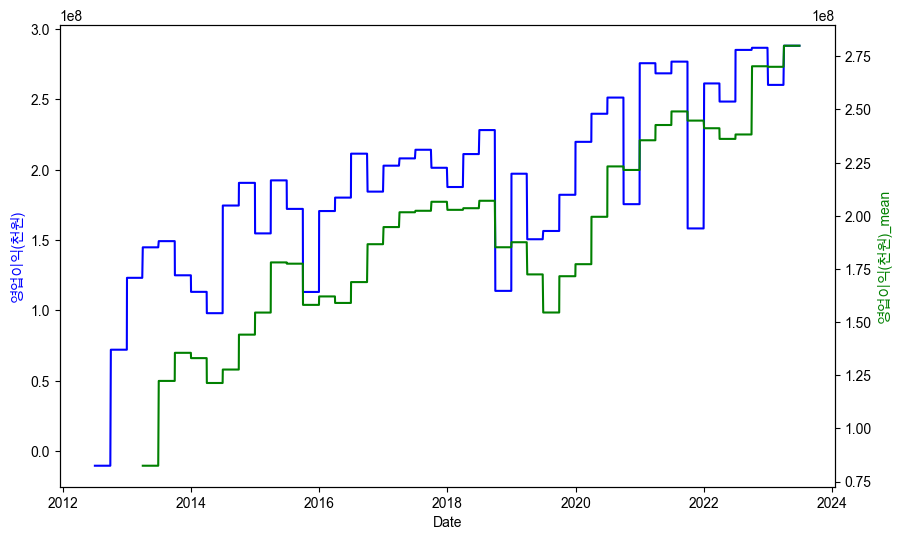

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# df는 이미 존재하는 DataFrame으로 가정합니다.

# 그래프 생성
plt.figure(figsize=(10, 6))

# 첫 번째 y축 (왼쪽)
ax1 = plt.gca()  # 현재의 Axes 객체를 가져옴
sns.lineplot(x='Date', y='영업이익(천원)', data=df, color='blue', ax=ax1)
ax1.set_ylabel('영업이익(천원)', color='blue')

# 두 번째 y축 (오른쪽)
ax2 = ax1.twinx()  # x축을 공유하는 새로운 Axes 객체 생성
sns.lineplot(x='Date', y='영업이익(천원)_mean', data=df, color='green', ax=ax2)
ax2.set_ylabel('영업이익(천원)_mean', color='green')

# # 세 번째 y축 (추가)
# ax3 = ax1.twinx()  # x축을 공유하는 또 다른 Axes 객체 생성
# sns.lineplot(x='Date', y='총자본(천원)', data=df, color='red', ax=ax3)
# ax3.set_ylabel('총자본(천원)', color='red')

# 세 번째 y축의 위치 조정
ax3.spines['right'].set_position(('outward', 60))  # 오른쪽으로 60pt 이동

# 그래프 제목 설정
plt.title('여러 컬럼의 라인 플롯')

# 그래프 표시
plt.show()


In [33]:
df_cleaned.columns

Index(['Date', '영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '종가(원)',
       '총자본(천원)', 'PBR(배)', 'us_10_treasury', 'Quarter', 'COE', 'YearQuarter',
       '영업이익(천원)_mean', '금융손익(비영업)(천원)_mean', '관계기업투자등관련손익(비영업)(천원)_mean',
       '총자본(천원)_mean'],
      dtype='object')

In [34]:
plt.plot(df_cleaned['당기순이익(천원)'])

KeyError: '당기순이익(천원)'

NameError: name 'ax3' is not defined

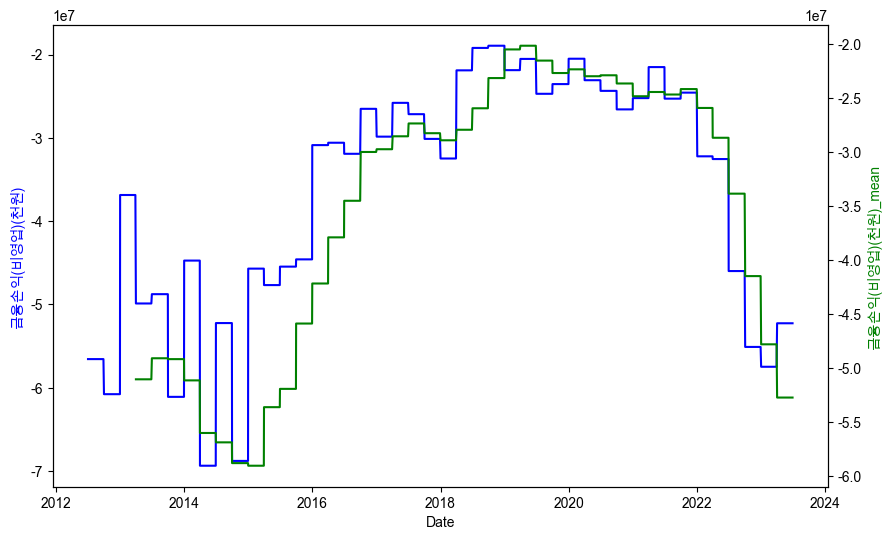

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# df는 이미 존재하는 DataFrame으로 가정합니다.

# 그래프 생성
plt.figure(figsize=(10, 6))

# 첫 번째 y축 (왼쪽)
ax1 = plt.gca()  # 현재의 Axes 객체를 가져옴
sns.lineplot(x='Date', y='금융손익(비영업)(천원)', data=df, color='blue', ax=ax1)
ax1.set_ylabel('금융손익(비영업)(천원)', color='blue')

# 두 번째 y축 (오른쪽)
ax2 = ax1.twinx()  # x축을 공유하는 새로운 Axes 객체 생성
sns.lineplot(x='Date', y='금융손익(비영업)(천원)_mean', data=df, color='green', ax=ax2)
ax2.set_ylabel('금융손익(비영업)(천원)_mean', color='green')

# # 세 번째 y축 (추가)
# ax3 = ax1.twinx()  # x축을 공유하는 또 다른 Axes 객체 생성
# sns.lineplot(x='Date', y='총자본(천원)', data=df, color='red', ax=ax3)
# ax3.set_ylabel('총자본(천원)', color='red')

# 세 번째 y축의 위치 조정
ax3.spines['right'].set_position(('outward', 60))  # 오른쪽으로 60pt 이동

# 그래프 제목 설정
plt.title('여러 컬럼의 라인 플롯')

# 그래프 표시
plt.show()


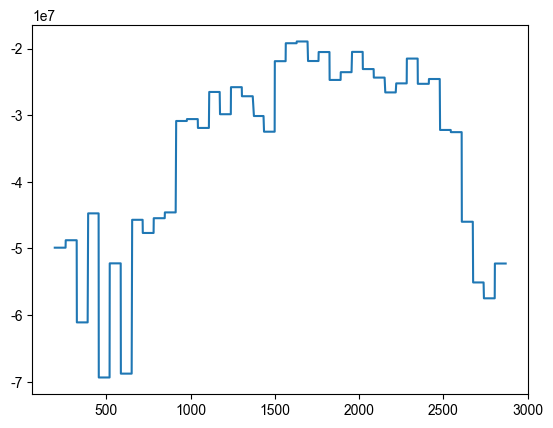

In [36]:
plt.plot(df_cleaned['금융손익(비영업)(천원)'])

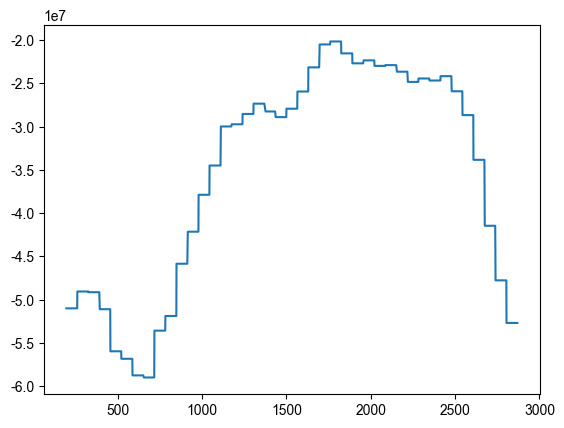

In [37]:
plt.plot(df_cleaned['금융손익(비영업)(천원)_mean'])

In [ ]:
# 모든 행 출력되도록
#pd.set_option('display.max_rows', None)

# 모든 컬럼 출력
#pd.set_option('display.max_columns', None)

### 시점&수익률 생성 

In [ ]:
# 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
df['종가_1주후'] = df['종가(원)'].shift(-5) # 1주
df['종가_2주후'] = df['종가(원)'].shift(-10) # 2주
df['종가_1달후'] = df['종가(원)'].shift(-20) # 1달
df['종가_3달후'] = df['종가(원)'].shift(-60) # 3달
df['종가_6달후'] = df['종가(원)'].shift(-120) # 6달

### 일반 수익률

In [ ]:
# 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
df['수익률_1주후'] = (df['종가_1주후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_2주후'] = (df['종가_2주후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_1달후'] = (df['종가_1달후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_3달후'] = (df['종가_3달후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_6달후'] = (df['종가_6달후'] - df['종가(원)']) / df['종가(원)'] * 100

### 코스피(시장) 수익률 계산

In [ ]:
# 코스피 지수 데이터 가져오기
df_kospi = yf.download('^KS11', start_dt, end_dt)
df_kospi = df_kospi.reset_index() # index -> column
df = df.merge(df_kospi[['Date', 'Adj Close']]) # df에 df_kospi "Adj Close" 값 병합
df.rename(columns={'Adj Close': 'kospi'}, inplace=True) # 컬럼명 변경

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
df['kospi_1주후'] = df['kospi'].shift(-5) # 1주
df['kospi_2주후'] = df['kospi'].shift(-10) # 2주
df['kospi_1달후'] = df['kospi'].shift(-20) # 1달
df['kospi_3달후'] = df['kospi'].shift(-60) # 3달
df['kospi_6달후'] = df['kospi'].shift(-120) # 6달

In [ ]:
# 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
df['kospi_수익률_1주후'] = (df['kospi_1주후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_2주후'] = (df['kospi_2주후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_1달후'] = (df['kospi_1달후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_3달후'] = (df['kospi_3달후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_6달후'] = (df['kospi_6달후'] - df['kospi']) / df['kospi'] * 100

In [ ]:
# 지수를 얼마나 이겼는지 (상대)수익률
df['상대수익률_1주후'] = df['수익률_1주후'] - df['kospi_수익률_1주후']
df['상대수익률_2주후'] = df['수익률_2주후'] - df['kospi_수익률_2주후']
df['상대수익률_1달후'] = df['수익률_1달후'] - df['kospi_수익률_1달후']
df['상대수익률_3달후'] = df['수익률_3달후'] - df['kospi_수익률_3달후']
df['상대수익률_6달후'] = df['수익률_6달후'] - df['kospi_수익률_6달후']

### 데이터 내보내기

In [ ]:
# # 저장할 폴더 경로 지정
# folder_path = '../gm_data'

# # 폴더가 없으면 생성
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # CSV 파일 저장
# df.to_csv(f'{folder_path}/{company}_df.csv', index=False)
